In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.testing as npt
import pandas as pd
from PIL import Image

# Opening the dataset labels file
To preprocess and combine the labels of the images with their identifying attributes and training features

In [2]:
attr_df = pd.read_table("./data/efigi-1.6/docs/EFIGI_attributes.txt", sep = '\s+')
attr_df['T'].unique

<bound method Series.unique of 0        1
1        0
2       -2
3        9
4        7
        ..
4453     6
4454     4
4455     3
4456     3
4457    10
Name: T, Length: 4458, dtype: int64>

In [3]:
hyper_df  = pd.read_table("./data/efigi-1.6/docs/EFIGI_HyperLeda.txt", sep = '\s+')
hyper_df

,PGC_name,PGC_no,vrad,e_vrad,vopt,e_vopt,v,e_v,vvir,zvir,z_err,type,objname,hl_names
0,PGC0000212,212.0,11230.4,4.5,11110.0,47.0,11229.3,9.0,11287.9,0.037650,0.000030,Sab,IC5381,PGC000212
1,PGC0000218,218.0,1050.3,4.8,1027.4,25.0,1049.5,4.5,1109.0,0.003699,0.000015,Sab,NGC7814,PGC1501809
2,PGC0000243,243.0,-9999.0,-9999.0,8914.3,16.3,8914.3,16.3,8841.8,0.029490,0.000054,S0,NGC7808,6dFJ0003321-104441
3,PGC0000255,255.0,878.1,4.1,-9999.0,-9999.0,878.1,4.1,932.9,0.003112,0.000014,Sm,UGC00017,PGC000255
4,PGC0000281,281.0,-9999.0,-9999.0,11490.7,16.4,11490.7,16.4,11416.0,0.038080,0.000055,Sc,PGC000281,MCG-02-01-015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,PGC0072806,72810.0,-9999.0,-9999.0,18356.6,15.9,18356.6,15.9,18341.9,0.061180,0.000053,S0-a,PGC072806,HCG098D
4454,PGC0072922,72920.0,6664.7,7.3,6717.8,20.8,6670.6,12.6,6648.3,0.022180,0.000042,Sb,IC1515,PGC197276
4455,PGC0072927,72930.0,7279.8,7.7,7279.0,18.5,7279.7,5.1,7257.8,0.024210,0.000017,Sbc,IC1516,HIPASSJ2356-00
4456,PGC0072930,72930.0,6668.0,5.2,6651.8,29.1,6667.5,4.1,6652.9,0.022190,0.000014,S0-a,NGC7787,MCG+00-01-005


## Merging the two data frames with only the relevant columns

In [4]:
hyper_df = hyper_df[['PGC_name','PGC_no','type']]
attr_df = attr_df[['PGCname','T','T_inf','T_sup']]
attr_df = attr_df.rename(columns={'PGCname':'PGC_name'})
attr_df = attr_df.merge(hyper_df)
attr_df

,PGC_name,T,T_inf,T_sup,PGC_no,type
0,PGC0000212,1,0,2,212.0,Sab
1,PGC0000218,0,-1,1,218.0,Sab
2,PGC0000243,-2,-3,-2,243.0,S0
3,PGC0000255,9,9,10,255.0,Sm
4,PGC0000281,7,6,9,281.0,Sc
...,...,...,...,...,...,...
4453,PGC0072806,6,4,8,72810.0,S0-a
4454,PGC0072922,4,3,4,72920.0,Sb
4455,PGC0072927,3,2,4,72930.0,Sbc
4456,PGC0072930,3,2,4,72930.0,S0-a


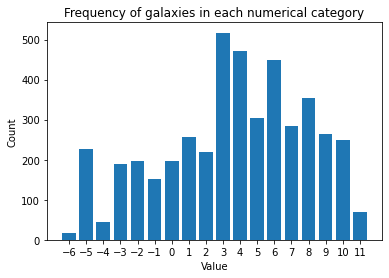

In [5]:
value_counts = attr_df['T'].value_counts()

fig, ax = plt.subplots()
ax.bar(value_counts.index, value_counts.values)
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax.set_title('Frequency of galaxies in each numerical category')
ax.set_xticks(range(-6, max(attr_df['T'])+1))
plt.show()

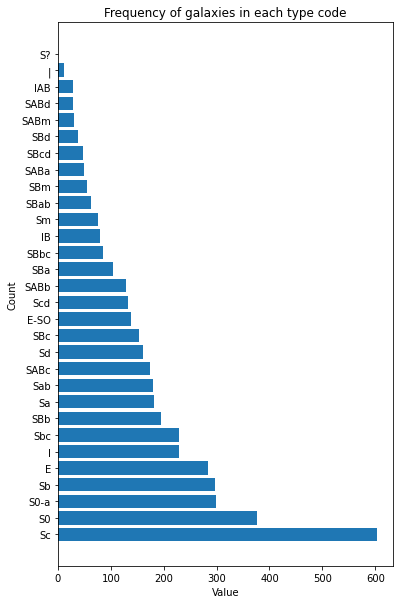

In [6]:
value_counts = attr_df['type'].value_counts()

fig, ax = plt.subplots(figsize=(6,10))
ax.barh(value_counts.index, value_counts.values)
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax.set_title('Frequency of galaxies in each type code')
plt.show()

# Encoding the numerical types to groups and naming them

This code converts type labels to a common integer, then uses the grouped labels to assign them the corresponding names of each type of galaxy

For reference, this is the overall grouping used:

k_encodings = {
    'Elliptical':(-6,-5,-4),
    'Lenticular_e':-3,
    'Lenticular_i':-2,
    'Lenticular_l':-1,
    'Irregular_m':(10,11),
    'Spiral':0,
    'Spiral_a':(1,2),
    'Spiral_b':(3,4),
    'Spiral_c':(5,6),
    'Spiral_d':(7,8),
    'Spiral_m':9
}

In [7]:
groups = {
    -6:0,
    -5:0,
    -4:0,
    -3:1,
    -2:2,
    -1:3,
    0:4,
    1:5,
    2:5,
    3:6,
    4:6,
    5:7,
    6:7,
    7:8,
    8:8,
    9:9,
    10:10,
    11:10
}

names = {
    0:'Elliptical',
    1:'Lenticular_e',
    2:'Lenticular_i',
    3:'Lenticular_l',
    4:'Spiral',
    5:'Spiral_a',
    6:'Spiral_b',
    7:'Spiral_c',
    8:'Spiral_d',
    9:'Spiral_m',
    10:'Irregular_m',
}


attr_df['groupT'] = attr_df['T'].map(groups)
attr_df['groupT'] = attr_df['groupT'].astype(int)
attr_df['labels'] = attr_df['groupT'].map(names)
attr_df[['PGC_name','T','groupT','labels']]
attr_df

,PGC_name,T,T_inf,T_sup,PGC_no,type,groupT,labels
0,PGC0000212,1,0,2,212.0,Sab,5,Spiral_a
1,PGC0000218,0,-1,1,218.0,Sab,4,Spiral
2,PGC0000243,-2,-3,-2,243.0,S0,2,Lenticular_i
3,PGC0000255,9,9,10,255.0,Sm,9,Spiral_m
4,PGC0000281,7,6,9,281.0,Sc,8,Spiral_d
...,...,...,...,...,...,...,...,...
4453,PGC0072806,6,4,8,72810.0,S0-a,7,Spiral_c
4454,PGC0072922,4,3,4,72920.0,Sb,6,Spiral_b
4455,PGC0072927,3,2,4,72930.0,Sbc,6,Spiral_b
4456,PGC0072930,3,2,4,72930.0,S0-a,6,Spiral_b


In [8]:
# names = np.array(attr_df['PGC_name'].to_list())
# print(names)
# image_dic = {}
# for name in names:
#     path = (f'./data/efigi-1.6/img_data/png/{name}.png')
#     img = Image.open(path)
#     img = img.convert('RGB')
#     img_array = np.array(img)
#     image_dic[name] = img_array

In [9]:
# image_dic['PGC0072272'].shape

# Creating X & y
training and testing data split 80/20 

In [10]:
# from sklearn.model_selection import train_test_split

# #features that lead to analysis of galaxy shape
# X = attr_df[['PGC_name']]

# #label for galaxy 
# y = attr_df['labels']

# #creating train and test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
img_list = attr_df['PGC_name'].to_list()[:200]
label_list = attr_df['labels'].to_list()[:200]

In [11]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

transform_train = transforms.Compose([
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, label_list, transform=None):
        self.img_list = img_list
        self.label_list = label_list
        self.transform= transform

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img = Image.open(f'./data/efigi-1.6/img_data/png/{img_name}.png').convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.label_list[idx]
        return img, label

img_list = attr_df['PGC_name'].to_list()[:200]
label_list = attr_df['groupT'].to_list()[:200]

dataset = CustomDataset(img_list, label_list, transform_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# Load pre-trained Wide ResNet model
model = models.wide_resnet50_2(pretrained=True)
model.eval()

# Define loss functiion
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Stop pre-trained layers from being changed
for param in model.parameters():
    param.require_grad=False

target_categories = ['Spiral_a', 'Spiral', 'Lenticular_i', 'Spiral_m', 'Spiral_d',
       'Spiral_c', 'Spiral_b', 'Elliptical', 'Irregular_m',
       'Lenticular_e', 'Lenticular_l']

model.fc = torch.nn.Linear(model.fc.in_features, len(target_categories))

for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        print(len(inputs))
        print(labels)
        outputs = model(inputs)
        print(outputs)
        loss = criterion(outputs, labels)
        print('reached 16')
        loss.backward()
        print('reached 17')
        optimizer.step()
        print('reached 18')

        running_loss += loss.item()
        if i%100 == 99:
            print('[%d, %5d] loss :%3f'%(epoch+1, i+1, running_loss/100))
            running_loss = 0.0

print('done trainin')


/home/sai/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sai/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


16
tensor([5, 7, 6, 5, 7, 8, 8, 8, 7, 8, 6, 6, 7, 8, 4, 2])
tensor([[ 1.6689e-01,  3.4088e-01,  8.0208e-02, -2.1297e-01, -7.1572e-03,
         -1.6869e-01, -6.1550e-01,  4.4719e-01,  1.3292e-01, -4.1604e-02,
         -1.6091e-01],
        [ 9.5511e-02,  3.4587e-01,  1.2498e-01,  1.7449e-01, -4.6756e-02,
          1.8033e-02, -5.9326e-01,  3.3688e-01,  3.7471e-01,  2.0653e-03,
         -2.9092e-01],
        [ 1.1293e-01,  5.1678e-01,  2.9917e-01,  2.2936e-02,  1.0026e-01,
         -8.0165e-02, -5.3440e-01,  1.6887e-01, -9.1149e-02, -4.2148e-02,
         -1.6950e-01],
        [ 1.6498e-01,  4.1297e-01,  1.6229e-01,  1.2033e-01, -2.2958e-02,
         -1.8132e-01, -4.0910e-01,  2.9159e-01, -1.0967e-01, -2.1048e-02,
          6.2346e-02],
        [ 2.4510e-01,  2.3688e-01,  3.3731e-03, -1.9677e-01, -1.9770e-01,
          6.7395e-02, -4.1972e-01,  2.8477e-01,  4.3180e-02, -1.1056e-01,
         -1.4447e-01],
        [ 2.7556e-01,  3.7517e-01, -2.0417e-01,  6.4455e-02, -1.0560e-01,
         -2

In [12]:
print(optimizer.step())

None


In [13]:
# import torch
# import torchvision.models as models
# import torchvision.transforms as transforms
# from PIL import Image

# # Load pre-trained Wide ResNet model
# model = models.wide_resnet50_2(pretrained=True)
# model.eval()

# # Define loss functiion
# loss = torch.nn.CrossEntropyLoss()

# # Define optimizer
# opt = torch.optim.Adam(model.parameters(), lr=0.001)

# # Stop pre-trained layers from being changed
# for param in model.parameters():
#     param.require_grad=False

# # Define classifier
# num_classes = 11
# target_categories = ['Spiral_a', 'Spiral', 'Lenticular_i', 'Spiral_m', 'Spiral_d',
#        'Spiral_c', 'Spiral_b', 'Elliptical', 'Irregular_m',
#        'Lenticular_e', 'Lenticular_l']

# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# # Define image transforms
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load dataframe that maps image names to categories
# df = attr_df

# # Define function to predict probabilities for a single image
# def predict(image_path):
#     # Load image
#     image = Image.open(image_path).convert("RGB")

#     # Apply image transforms
#     image = transform(image)

#     # Add batch dimension
#     image = image.unsqueeze(0)

#     # Make prediction
#     with torch.no_grad():
#         outputs = model(image)

#     # Get probabilities and convert to numpy array
#     probs = torch.softmax(outputs, dim=1).numpy()[0]

#     # Return dictionary of probabilities for each target category
#     return {category: prob for category, prob in zip(target_categories, probs)}

# def max_prob(dict):
#   return max(dict, key = dict.get), max(dict, key=dict.get)

# # Loop through all images and predict probabilities for each
# for name, label in zip(df["PGC_name"][:50], df["labels"][:50]):
#     image_path = (f'./data/efigi-1.6/img_data/png/{name}.png')
#     probs = predict(image_path)
#     highest_label= max_prob(probs)[0]
#     highest_prob = probs[highest_label]
#     print(f"Image {name} has highest probability for {highest_label}, with value {highest_prob} for original category {label}")
